In [ ]:
# just for Google Colab compatibility
# This code is not part of the original files, but is necessary to run them in Google Colab.
# It mounts Google Drive and sets the working directory to the repository path.
from google.colab import drive
drive.mount('/content/drive')
import os, sys
repo = '/content/drive/MyDrive/university/Optimization/frank-wolf-optimization'
os.chdir(repo)
sys.path.append(os.path.join(repo, 'src'))
!ls


=== Dataset: ml-100k ===
μ_train=3.531, τ≈476.719 → using τ=476.719
--- FW-analytic ---


FW:   8%|██████▏                                                                       | 16/200 [00:00<00:03, 57.77it/s]


Finished FW-analytic in 0.29s, iters=16
RMSE eval: 0.01s
--- FW-vanilla ---


FW:  12%|█████████▊                                                                    | 25/200 [00:00<00:02, 70.22it/s]


Finished FW-vanilla in 0.37s, iters=25
RMSE eval: 0.02s
--- PFW-analytic ---


PFW:   2%|█▌                                                                            | 4/200 [00:00<00:04, 45.23it/s]


Finished PFW-analytic in 0.10s, iters=5
RMSE eval: 0.00s
--- PFW-vanilla ---


PFW:  24%|██████████████████▊                                                          | 49/200 [00:01<00:03, 46.25it/s]


Finished PFW-vanilla in 1.07s, iters=50
RMSE eval: 0.02s

=== Summary ===
Dataset     Method                  Iter    Solve(s)     Eval(s)   RMSE_tr     RMSE_te    NRMSE_tr    NRMSE_te     R2_tr       R2_te
------------------------------------------------------------------------------------------------------------------------------------
ml-100k     FW-analytic               16        0.29        0.01    0.9357      0.9929      0.1871      0.1986    0.3090      0.2221
ml-100k     FW-vanilla                25        0.37        0.02    0.9321      0.9918      0.1864      0.1984    0.3143      0.2238
ml-100k     PFW-analytic               5        0.10        0.00    1.0330      1.0552      0.2066      0.2110    0.1579      0.1214
ml-100k     PFW-vanilla               50        1.07        0.02    0.9215      0.9886      0.1843      0.1977    0.3298      0.2288


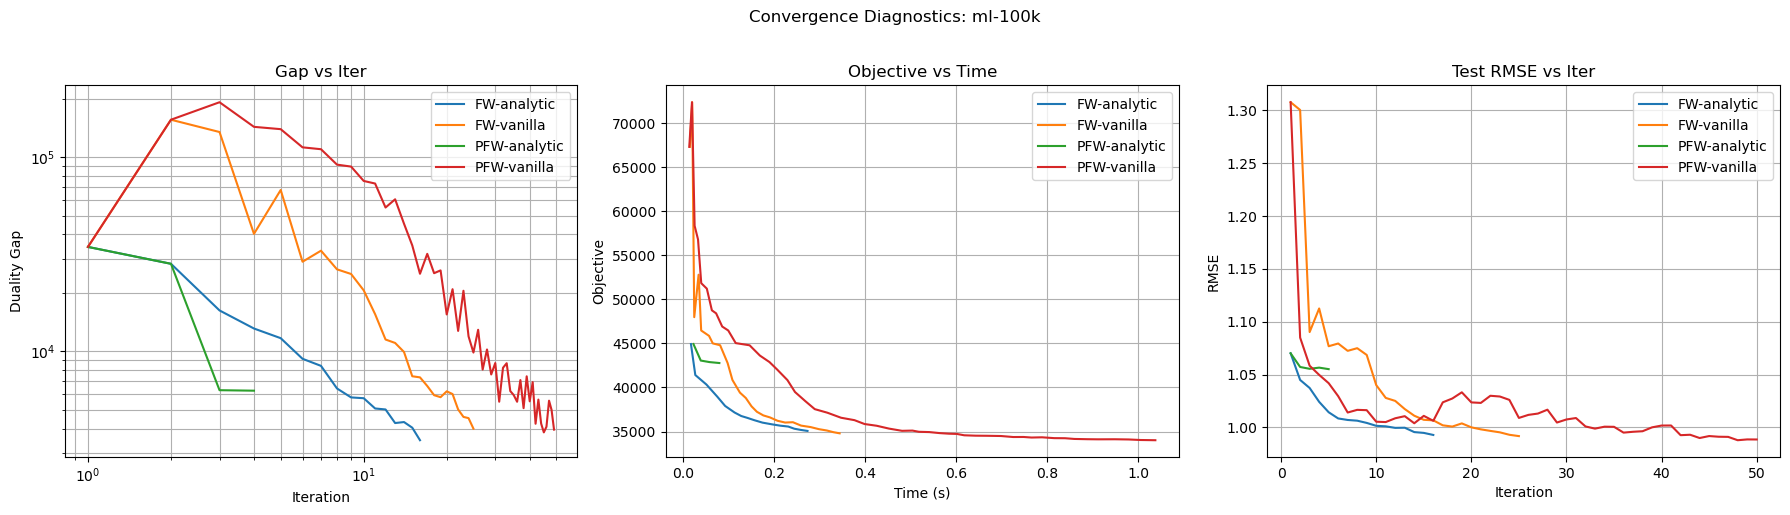

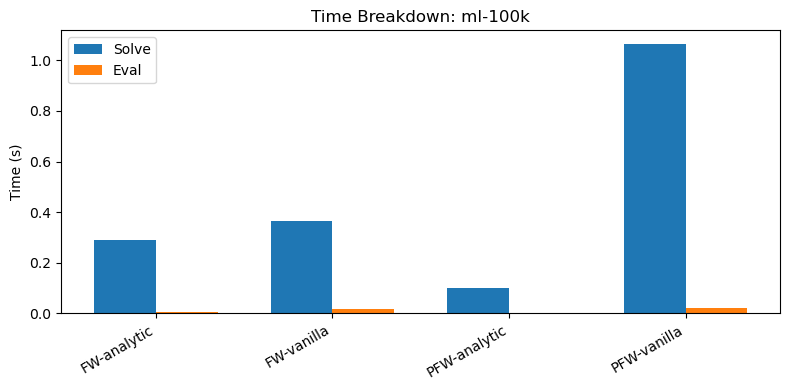

In [6]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from utils import load_dataset, evaluate, approximate_nuclear_norm
from solvers import (
    MatrixCompletionObjective,
    nuclear_norm_lmo,
    FrankWolfe,
    PairwiseFrankWolfe,
)

# ----------------------------------------------------------------------------
# Configuration
# ----------------------------------------------------------------------------
config = {
    'datasets':           ['ml-100k'],
    'steps':              ['analytic', 'vanilla'],
    'test_fraction':      0.2,
    'seed':               42,
    'tau_scale':          1.0,
    'max_iter':           200,
    'tol':                1e-1,
    'snapshot_interval':  5,
    'tau_approx_k':       12,
    'fixed_step':         0.1,
    'save_plots':         False,
    'plot_dir':           'plots',
}

if config['save_plots']:
    os.makedirs(config['plot_dir'], exist_ok=True)

# ----------------------------------------------------------------------------
# Plotting helpers
# ----------------------------------------------------------------------------
def _save_or_show(filename=None):
    if config['save_plots'] and filename:
        path = os.path.join(config['plot_dir'], filename)
        plt.savefig(path, dpi=300, bbox_inches='tight')
        print(f"Saved plot: {path}")
    plt.show()

# Convergence 3-panel
def plot_convergence(results, dataset):
    # Flatten results
    flat = {f"{s}-{step}": d
            for s, dd in results[dataset].items()
            for step, d in dd.items()}
    methods = list(flat.keys())
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    # Gap vs Iter
    ax = axes[0]
    for m in methods:
        d = flat[m]
        x, y = np.array(d['snap_iters']), np.array(d['gap'])
        L = min(len(x), len(y))
        ax.loglog(x[:L], y[:L], label=m)
    ax.set(title='Gap vs Iter', xlabel='Iteration', ylabel='Duality Gap')
    ax.grid(True, which='both'); ax.legend()
    # Obj vs Time
    ax = axes[1]
    for m in methods:
        d = flat[m]
        x, y = np.array(d['times']), np.array(d['obj_vals'])
        L = min(len(x), len(y))
        ax.plot(x[:L], y[:L], label=m)
    ax.set(title='Objective vs Time', xlabel='Time (s)', ylabel='Objective')
    ax.grid(True); ax.legend()
    # RMSE vs Iter
    ax = axes[2]
    for m in methods:
        d = flat[m]
        x, y = np.array(d['snap_iters']), np.array(d['rmse_test'])
        L = min(len(x), len(y))
        ax.plot(x[:L], y[:L], label=m)
    ax.set(title='Test RMSE vs Iter', xlabel='Iteration', ylabel='RMSE')
    ax.grid(True); ax.legend()
    plt.suptitle(f'Convergence Diagnostics: {dataset}', y=1.02)
    plt.tight_layout()
    _save_or_show(f"{dataset}_convergence.png")

# Solve vs Eval bar chart
def plot_time_breakdown(summary_rows):
    # summary_rows: (dataset, method, ..., t_solve, t_eval)
    import pandas as pd
    df = pd.DataFrame(summary_rows,
                      columns=[ 'dataset','method','rmse_tr','rmse_te',
                                'nrm_tr','nrm_te','r2_tr','r2_te',
                                'iters','t_solve','t_eval'])
    for ds in df['dataset'].unique():
        sub = df[df['dataset']==ds]
        methods = sub['method'].tolist()
        solve = sub['t_solve'].astype(float).values
        eval_  = sub['t_eval'].astype(float).values
        x = np.arange(len(methods))
        width = 0.35
        plt.figure(figsize=(8,4))
        plt.bar(x - width/2, solve, width, label='Solve')
        plt.bar(x + width/2, eval_,  width, label='Eval')
        plt.xticks(x, methods, rotation=30, ha='right')
        plt.ylabel('Time (s)'); plt.title(f'Time Breakdown: {ds}')
        plt.legend(); plt.tight_layout()
        _save_or_show(f"{ds}_time_breakdown.png")

# Heatmap of final test RMSE
def plot_heatmap(summary_rows):
    import pandas as pd
    df = pd.DataFrame(summary_rows,
                      columns=[ 'dataset','method','rmse_tr','rmse_te',
                                'nrm_tr','nrm_te','r2_tr','r2_te',
                                'iters','t_solve','t_eval'])
    pivot = df.pivot(index='dataset', columns='method', values='rmse_te')
    plt.figure(figsize=(8,3))
    im = plt.imshow(pivot, aspect='auto', cmap='viridis')
    plt.xticks(np.arange(pivot.shape[1]), pivot.columns, rotation=45, ha='right')
    plt.yticks(np.arange(pivot.shape[0]), pivot.index)
    plt.colorbar(im, label='Test RMSE')
    plt.title('Final Test RMSE Heatmap')
    plt.tight_layout()
    _save_or_show('heatmap_rmse.png')

# ----------------------------------------------------------------------------
# Experiment Runner
# ----------------------------------------------------------------------------
class ExperimentRunner:
    def __init__(self, cfg):
        self.cfg = cfg
        self.results = {}
        self.summary_rows = []

    def run(self):
        for dataset in self.cfg['datasets']:
            print(f"\n=== Dataset: {dataset} ===")
            M_obs, mask_train, mask_test, M_true = load_dataset(
                name=dataset,
                test_fraction=self.cfg['test_fraction'],
                seed=self.cfg['seed']
            )
            mu_tr = M_true[mask_train].mean()
            M_obs_centered = M_obs.copy(); M_obs_centered.data -= mu_tr

            # Pre-extract indices
            rows_tr, cols_tr = np.where(mask_train)
            rows_te, cols_te = np.where(mask_test)
            y_tr = M_true[rows_tr, cols_tr] - mu_tr
            y_te = M_true[rows_te, cols_te] - mu_tr
            SST_tr = (y_tr**2).sum(); SST_te = (y_te**2).sum()

            obj = MatrixCompletionObjective(M_obs_centered, mask_train)
            def_tau = approximate_nuclear_norm(M_obs_centered, k=self.cfg['tau_approx_k'])
            tau = self.cfg['tau_scale'] * def_tau
            print(f"μ_train={mu_tr:.3f}, τ≈{def_tau:.3f} → using τ={tau:.3f}")

            ds_map = {}
            for solver_name, Solver in [('FW', FrankWolfe), ('PFW', PairwiseFrankWolfe)]:
                solver_map = {}
                for step in self.cfg['steps']:
                    print(f"--- {solver_name}-{step} ---")
                    solver = Solver(
                        objective=obj,
                        lmo_function=nuclear_norm_lmo,
                        tau=tau,
                        max_iter=self.cfg['max_iter'],
                        tol=self.cfg['tol'],
                        abs_tol=1e-6,
                        snapshot_interval=self.cfg['snapshot_interval'],
                        step_method=step,
                        fixed_step=self.cfg['fixed_step']
                    )
                    t0 = time.time(); solver.run(); t_solve = time.time() - t0
                    iters = len(solver.weights_history)
                    print(f"Finished {solver_name}-{step} in {t_solve:.2f}s, iters={iters}")

                    # stack atoms
                    R = len(solver.atoms)
                    U = np.vstack([a.u.ravel() for a in solver.atoms])
                    V = np.vstack([a.v.ravel() for a in solver.atoms])
                    T = np.array([a.tau for a in solver.atoms])[:,None]
                    A_tr = -T * (U[:, rows_tr] * V[:, cols_tr])
                    A_te = -T * (U[:, rows_te] * V[:, cols_te])



                    # 1) Build W from your history
                    iters = len(solver.weights_history)
                    R_max = max(len(ws) for ws in solver.weights_history)
                    W = np.zeros((iters, R_max))
                    for i, ws in enumerate(solver.weights_history):
                        W[i, :len(ws)] = ws
                
                    # 2) Stack your final atoms
                    U = np.vstack([a.u.ravel() for a in solver.atoms])    # (R_final, m*n)
                    V = np.vstack([a.v.ravel() for a in solver.atoms])    # (R_final, m*n)
                    T = np.array([a.tau for a in solver.atoms])[:, None]  # (R_final, 1)
                
                    # 3) Build A_tr, A_te from them
                    A_tr = -T * (U[:, rows_tr] * V[:, cols_tr])
                    A_te = -T * (U[:, rows_te] * V[:, cols_te])
                
                    # 4) **Auto-align dimensions**: pad whichever side is smaller
                    nW, nA = W.shape[1], A_tr.shape[0]
                    if nW < nA:
                        # Weight matrix too skinny → pad W with zero-cols
                        pad = nA - nW
                        W = np.hstack([W, np.zeros((iters, pad))])
                    elif nA < nW:
                        # Atom matrices too short → pad A_tr/A_te with zero-rows
                        pad = nW - nA
                        A_tr = np.vstack([A_tr, np.zeros((pad, A_tr.shape[1]))])
                        A_te = np.vstack([A_te, np.zeros((pad, A_te.shape[1]))])
                
                    # 5) Now shapes line up: (iters × R) @ (R × n_obs)
                    t1 = time.time()
                    rmse_tr = np.sqrt(((W @ A_tr - y_tr[None, :])**2).mean(axis=1))
                    rmse_te = np.sqrt(((W @ A_te - y_te[None, :])**2).mean(axis=1))
                    t_eval = time.time() - t1
                    print(f"RMSE eval: {t_eval:.2f}s")

                    # diagnostics storage
                    solver_map[step] = {
                        'snap_iters': np.arange(1, iters+1),
                        'gap': np.array([h[1] for h in solver.history]),
                        'obj_vals': np.array([h[2] for h in solver.history]),
                        'times': np.array(solver.times[1:iters+1]),
                        'rmse_test': rmse_te
                    }

                    # summary row
                    final_tr, final_te = rmse_tr[-1], rmse_te[-1]
                    rating_range = M_true.max() - M_true.min()
                    nrm_tr = final_tr / rating_range
                    nrm_te = final_te / rating_range
                    R2_tr = 1 - final_tr**2 * mask_train.sum() / SST_tr
                    R2_te = 1 - final_te**2 * mask_test.sum()   / SST_te
                    self.summary_rows.append((dataset,
                                              f"{solver_name}-{step}",
                                              final_tr, final_te,
                                              nrm_tr, nrm_te,
                                              R2_tr, R2_te,
                                              iters, t_solve, t_eval))
                ds_map[solver_name] = solver_map
            self.results[dataset] = ds_map
        return self.results, self.summary_rows

# ----------------------------------------------------------------------------
# Main Execution
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    runner = ExperimentRunner(config)
    results, summary_rows = runner.run()

    # Print summary table
    hdr = (
        f"{'Dataset':10s}  {'Method':20s}  {'Iter':>6s}  {'Solve(s)':>10s}  {'Eval(s)':>10s}"
        f"{'RMSE_tr':>10s}  {'RMSE_te':>10s}  {'NRMSE_tr':>10s}  {'NRMSE_te':>10s}"
        f"{'R2_tr':>10s}  {'R2_te':>10s}"
    )
    print("\n=== Summary ===")
    print(hdr)
    print('-'*len(hdr))
    for (ds, method, rmse_tr, rmse_te, nrm_tr, nrm_te,
         R2_tr, R2_te, iters, t_solve, t_eval) in summary_rows:
        print(f"{ds:10s}  {method:20s}  {iters:6d}  {t_solve:10.2f}  {t_eval:10.2f}"
              f"{rmse_tr:10.4f}  {rmse_te:10.4f}  {nrm_tr:10.4f}  {nrm_te:10.4f}"
              f"{R2_tr:10.4f}  {R2_te:10.4f}")

    # Generate plots
    for ds in config['datasets']:
        plot_convergence(results, ds)
    plot_time_breakdown(summary_rows)
    # plot_heatmap(summary_rows)
    # plot_performance_scatter(summary_rows)